# &nbsp; 1. Initiating

## &nbsp; 1.1 Install Libraries

In [1]:
# Holy grail
import numpy as np
import pandas as pd
from jinja2.utils import concat
from numpy.ma.core import concatenate

# Scikit-learn
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import GroupKFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import branca.colormap as cm
import seaborn as sns
import folium

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb

## &nbsp; 1.2 Connect to G-Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import warnings
warnings.filterwarnings('ignore')

## &nbsp; 1.3 Load Data

In [137]:
# file_path = "train.csv"
file_path='data_forecast.csv'
df = pd.read_csv(file_path)

In [92]:
df.head()

,Tanggal,Bahan_pangan,Daerah,Harga_lag_1,Harga_lag_7,Harga_lag_30,Google_trends,Harga
0,2024-10-01,Bawang Merah,Aceh,28960,27700,26390,0,0
1,2024-10-01,Bawang Merah,Bali,24230,24240,21250,0,0
2,2024-10-01,Bawang Merah,Banten,27940,25910,25520,0,0
3,2024-10-01,Bawang Merah,Bengkulu,27390,26960,23840,0,0
4,2024-10-01,Bawang Merah,DI Yogyakarta,24450,22240,19600,0,0


# &nbsp; 2. EDA

## &nbsp; 2.1 Statistical Description

In [93]:
df.shape

(40664, 8)

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40664 entries, 0 to 40663
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tanggal        40664 non-null  object
 1   Bahan_pangan   40664 non-null  object
 2   Daerah         40664 non-null  object
 3   Harga_lag_1    40664 non-null  int64 
 4   Harga_lag_7    40664 non-null  int64 
 5   Harga_lag_30   40664 non-null  int64 
 6   Google_trends  40664 non-null  int64 
 7   Harga          40664 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 2.5+ MB


In [138]:
# Cek contoh nilai unik dalam kolom Tanggal
print(df['Tanggal'].unique()[:10])  # Melihat 10 nilai unik pertama

# Konversi 'Tanggal' ke datetime dengan format yang lebih fleksibel
df['Tanggal'] = pd.to_datetime(df['Tanggal'], errors='coerce')

# Cek apakah ada nilai yang gagal dikonversi
print(df[df['Tanggal'].isna()])

# Jika ada nilai NaN, bisa dihapus atau ditangani secara khusus
df = df.dropna(subset=['Tanggal'])

# Konversi kolom numerik
num_cols = ['Harga_lag_1', 'Harga_lag_7',
            'Harga_lag_30', 'Google_trends',
            'MYRUSD', 'SGDUSD',
            'THBUSD', 'USDIDR', 'Harga']

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

['2024-10-01' '2024-10-02' '2024-10-03' '2024-10-04' '2024-10-05'
 '2024-10-06' '2024-10-07' '2024-10-08' '2024-10-09' '2024-10-10']
Empty DataFrame
Columns: [Tanggal, Bahan_pangan, Daerah, Harga_lag_1, Harga_lag_7, Harga_lag_30, Google_trends, Harga]
Index: []


KeyError: "['MYRUSD', 'SGDUSD', 'THBUSD', 'USDIDR'] not in index"

In [ ]:
# # Hapus baris dengan indeks 53358
# df = df.drop(index=53358).reset_index(drop=True)

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40664 entries, 0 to 40663
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Tanggal        40664 non-null  datetime64[ns]
 1   Bahan_pangan   40664 non-null  object        
 2   Daerah         40664 non-null  object        
 3   Harga_lag_1    40664 non-null  int64         
 4   Harga_lag_7    40664 non-null  int64         
 5   Harga_lag_30   40664 non-null  int64         
 6   Google_trends  40664 non-null  int64         
 7   Harga          40664 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 2.5+ MB


In [97]:
df.describe()

,Tanggal,Harga_lag_1,Harga_lag_7,Harga_lag_30,Google_trends,Harga
count,40664,"40,664","40,664","40,664","40,664","40,664"
mean,2024-11-15 12:00:00,377,"2,646","11,766",0,0
min,2024-10-01 00:00:00,0,0,0,0,0
25%,2024-10-23 18:00:00,0,0,0,0,0
50%,2024-11-15 12:00:00,0,0,0,0,0
75%,2024-12-08 06:00:00,0,0,"16,330",0,0
max,2024-12-31 00:00:00,"158,210","162,480","162,480",0,0
std,NaN,"4,939","12,879","25,160",0,0


In [139]:
duplicate_rows = df.duplicated()
print("Jumlah baris duplikat:", duplicate_rows.sum())

Jumlah baris duplikat: 0


In [140]:
missing_values = df.isnull().sum()
print("Jumlah missing values per kolom:\n", missing_values)

Jumlah missing values per kolom:
 Tanggal          0
Bahan_pangan     0
Daerah           0
Harga_lag_1      0
Harga_lag_7      0
Harga_lag_30     0
Google_trends    0
Harga            0
dtype: int64


## &nbsp; 2.2 Adjustment Features

In [141]:
print((df == 0).sum())

Tanggal              0
Bahan_pangan         0
Daerah               0
Harga_lag_1      40223
Harga_lag_7      37583
Harga_lag_30     27020
Google_trends    40664
Harga            40664
dtype: int64


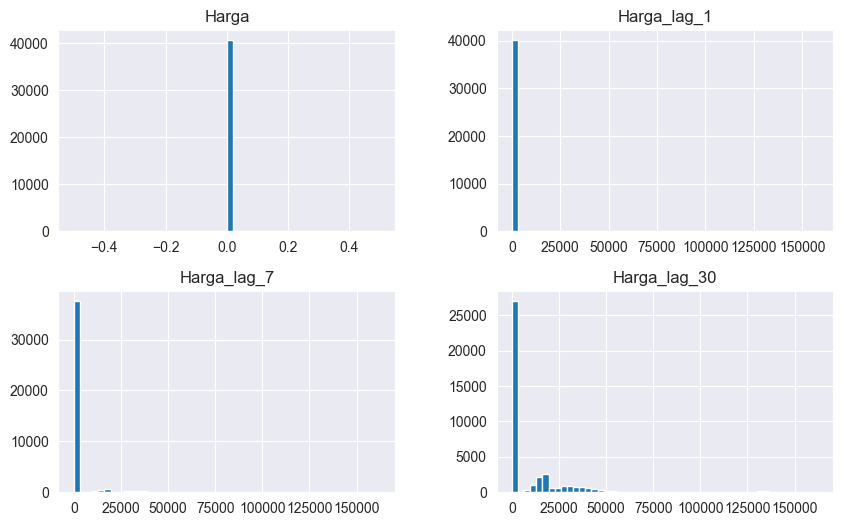

In [142]:
df[['Harga', 'Harga_lag_1', 'Harga_lag_7', 'Harga_lag_30']].hist(bins=50, figsize=(10,6))
plt.show()

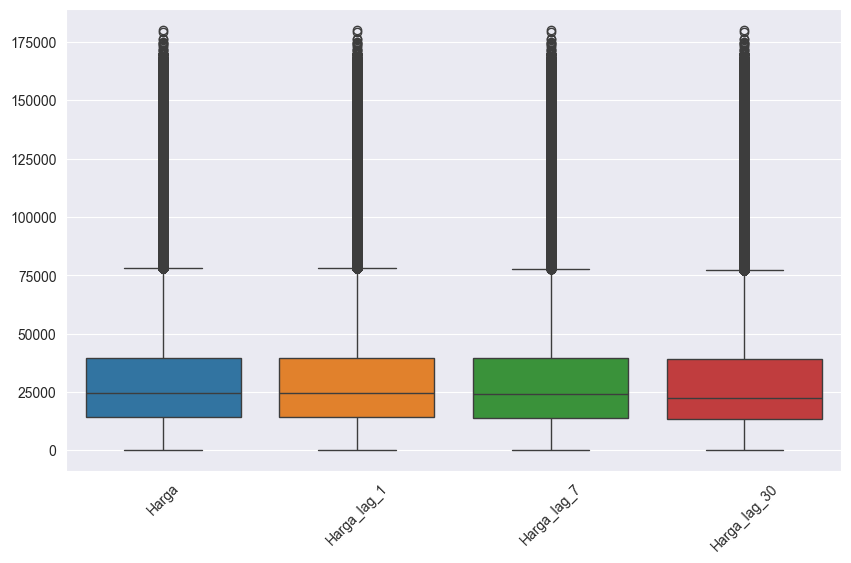

In [15]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df[['Harga', 'Harga_lag_1', 'Harga_lag_7', 'Harga_lag_30']])
plt.xticks(rotation=45)
plt.show()

In [16]:
# Ubah nilai 0 menjadi NaN untuk kolom yang seharusnya tidak memiliki nilai 0
cols_with_zeros = ['Harga_lag_1', 'Harga_lag_7', 'Harga_lag_30', 'Google_trends',
                   'MYRUSD', 'SGDUSD', 'THBUSD', 'USDIDR', 'Harga']
df[cols_with_zeros] = df[cols_with_zeros].replace(0, pd.NA)

In [17]:
df.head()

,Tanggal,Bahan_pangan,Daerah,Harga_lag_1,Harga_lag_7,Harga_lag_30,Google_trends,MYRUSD,SGDUSD,THBUSD,USDIDR,Harga
0,2022-01-01,Bawang Merah,Aceh,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,28970.0
1,2022-01-01,Bawang Merah,Bali,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,20870.0
2,2022-01-01,Bawang Merah,Banten,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,26890.0
3,2022-01-01,Bawang Merah,Aceh,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,28970.0
4,2022-01-01,Bawang Merah,Bali,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,20870.0


In [18]:
df.tail()

,Tanggal,Bahan_pangan,Daerah,Harga_lag_1,Harga_lag_7,Harga_lag_30,Google_trends,MYRUSD,SGDUSD,THBUSD,USDIDR,Harga
471044,2024-09-30,Tepung Terigu (Curah),Sulawesi Tenggara,9680.0,9720.0,9810.0,<NA>,3670.3084,11804.482,467.3261,15118.0,9620.0
471045,2024-09-30,Tepung Terigu (Curah),Sulawesi Utara,10760.0,10760.0,10770.0,<NA>,3670.3084,11804.482,467.3261,15118.0,10690.0
471046,2024-09-30,Tepung Terigu (Curah),Sumatera Barat,9830.0,9760.0,9800.0,<NA>,3670.3084,11804.482,467.3261,15118.0,9920.0
471047,2024-09-30,Tepung Terigu (Curah),Sumatera Selatan,8960.0,8940.0,8970.0,<NA>,3670.3084,11804.482,467.3261,15118.0,8960.0
471048,2024-09-30,Tepung Terigu (Curah),Sumatera Utara,10710.0,10520.0,10870.0,<NA>,3670.3084,11804.482,467.3261,15118.0,10640.0


In [19]:
df.isna().mean() * 100

Tanggal           0.000000
Bahan_pangan      0.000000
Daerah            0.000000
Harga_lag_1       5.054899
Harga_lag_7       5.653139
Harga_lag_30      7.996425
Google_trends    76.624251
MYRUSD            0.255176
SGDUSD            0.255176
THBUSD            0.255176
USDIDR            0.255176
Harga             4.887400
dtype: float64

In [20]:
# Isi harga yang hilang dengan median per bahan pangan dan daerah
df['Harga'] = df.groupby(['Bahan_pangan', 'Daerah'])['Harga'].transform(lambda x: x.fillna(x.median()))

# Isi nilai tukar dengan rata-rata 7 hari sebelumnya
df[['MYRUSD', 'SGDUSD', 'THBUSD', 'USDIDR']] = df[['MYRUSD', 'SGDUSD', 'THBUSD', 'USDIDR']].fillna(method='ffill', limit=7)

In [21]:
df.describe()

,Tanggal,Harga
count,471048,471048.000000
mean,2023-04-23 13:12:54.586029056,35896.007021
min,2022-01-01 00:00:00,7480.000000
25%,2022-07-24 00:00:00,14650.000000
50%,2023-04-17 00:00:00,26170.000000
75%,2024-01-08 00:00:00,40460.000000
max,2024-09-30 00:00:00,180000.000000
std,NaN,33359.221338


In [22]:
df.shape

(471048, 12)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 471048 entries, 0 to 471048
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Tanggal        471048 non-null  datetime64[ns]
 1   Bahan_pangan   471048 non-null  object        
 2   Daerah         471048 non-null  object        
 3   Harga_lag_1    447237 non-null  object        
 4   Harga_lag_7    444419 non-null  object        
 5   Harga_lag_30   433381 non-null  object        
 6   Google_trends  110111 non-null  object        
 7   MYRUSD         469846 non-null  object        
 8   SGDUSD         469846 non-null  object        
 9   THBUSD         469846 non-null  object        
 10  USDIDR         469846 non-null  object        
 11  Harga          471048 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 46.7+ MB


In [24]:
# Konversi kolom numerik
num_cols = ['Harga_lag_1', 'Harga_lag_7',
            'Harga_lag_30', 'Google_trends',
            'MYRUSD', 'SGDUSD',
            'THBUSD', 'USDIDR', 'Harga']

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

In [143]:
num_cols = ['Google_trends']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40664 entries, 0 to 40663
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Tanggal        40664 non-null  datetime64[ns]
 1   Bahan_pangan   40664 non-null  object        
 2   Daerah         40664 non-null  object        
 3   Harga_lag_1    40664 non-null  int64         
 4   Harga_lag_7    40664 non-null  int64         
 5   Harga_lag_30   40664 non-null  int64         
 6   Google_trends  40664 non-null  int64         
 7   Harga          40664 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 2.5+ MB


In [106]:
df.describe()

,Tanggal,Harga_lag_1,Harga_lag_7,Harga_lag_30,Google_trends,Harga
count,40664,"40,664","40,664","40,664","40,664","40,664"
mean,2024-11-15 12:00:00,377,"2,646","11,766",0,0
min,2024-10-01 00:00:00,0,0,0,0,0
25%,2024-10-23 18:00:00,0,0,0,0,0
50%,2024-11-15 12:00:00,0,0,0,0,0
75%,2024-12-08 06:00:00,0,0,"16,330",0,0
max,2024-12-31 00:00:00,"158,210","162,480","162,480",0,0
std,NaN,"4,939","12,879","25,160",0,0


In [27]:
# Pilih hanya kolom numerik (float64) untuk dibulatkan
num_cols = df.select_dtypes(include=['float64']).columns

# Bulatkan dan ubah ke bilangan bulat
df[num_cols] = df[num_cols].round(0).astype('Int64')

### 2.2.1 Result of Imputation

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 471048 entries, 0 to 471048
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Tanggal        471048 non-null  datetime64[ns]
 1   Bahan_pangan   471048 non-null  object        
 2   Daerah         471048 non-null  object        
 3   Harga_lag_1    447237 non-null  Int64         
 4   Harga_lag_7    444419 non-null  Int64         
 5   Harga_lag_30   433381 non-null  Int64         
 6   Google_trends  110111 non-null  Int64         
 7   MYRUSD         469846 non-null  Int64         
 8   SGDUSD         469846 non-null  Int64         
 9   THBUSD         469846 non-null  Int64         
 10  USDIDR         469846 non-null  Int64         
 11  Harga          471048 non-null  Int64         
dtypes: Int64(9), datetime64[ns](1), object(2)
memory usage: 50.8+ MB


In [29]:
df.describe()

,Tanggal,Harga_lag_1,Harga_lag_7,Harga_lag_30,Google_trends,MYRUSD,SGDUSD,THBUSD,USDIDR,Harga
count,471048,447237.0,444419.0,433381.0,110111.0,469846.0,469846.0,469846.0,469846.0,471048.0
mean,2023-04-23 13:12:54.586029056,36168.703998,36175.916871,36167.109333,37.980792,3379.565381,11235.33302,434.557855,15213.318909,35896.007021
min,2022-01-01 00:00:00,7480.0,7480.0,7480.0,1.0,3206.0,10438.0,399.0,14215.0,7480.0
25%,2022-07-24 00:00:00,14660.0,14650.0,14620.0,25.0,3312.0,10676.0,427.0,14816.0,14650.0
50%,2023-04-17 00:00:00,26460.0,26460.0,26460.0,39.0,3361.0,11308.0,436.0,15216.0,26170.0
75%,2024-01-08 00:00:00,40650.0,40690.0,40730.0,52.0,3430.0,11644.0,443.0,15621.0,40460.0
max,2024-09-30 00:00:00,180000.0,180000.0,180000.0,100.0,3682.0,12230.0,467.0,16492.0,180000.0
std,NaN,33542.351582,33544.117676,33545.860371,20.907236,90.081199,507.84821,13.287068,580.915559,33359.221338


In [30]:
# Format angka dalam df.describe() agar tampil sebagai bilangan bulat
pd.options.display.float_format = '{:,.0f}'.format

In [31]:
df.describe()

,Tanggal,Harga_lag_1,Harga_lag_7,Harga_lag_30,Google_trends,MYRUSD,SGDUSD,THBUSD,USDIDR,Harga
count,471048,"447,237","444,419","433,381","110,111","469,846","469,846","469,846","469,846","471,048"
mean,2023-04-23 13:12:54.586029056,"36,169","36,176","36,167",38,"3,380","11,235",435,"15,213","35,896"
min,2022-01-01 00:00:00,"7,480","7,480","7,480",1,"3,206","10,438",399,"14,215","7,480"
25%,2022-07-24 00:00:00,"14,660","14,650","14,620",25,"3,312","10,676",427,"14,816","14,650"
50%,2023-04-17 00:00:00,"26,460","26,460","26,460",39,"3,361","11,308",436,"15,216","26,170"
75%,2024-01-08 00:00:00,"40,650","40,690","40,730",52,"3,430","11,644",443,"15,621","40,460"
max,2024-09-30 00:00:00,"180,000","180,000","180,000",100,"3,682","12,230",467,"16,492","180,000"
std,NaN,"33,542","33,544","33,546",21,90,508,13,581,"33,359"


In [32]:
df.tail()

,Tanggal,Bahan_pangan,Daerah,Harga_lag_1,Harga_lag_7,Harga_lag_30,Google_trends,MYRUSD,SGDUSD,THBUSD,USDIDR,Harga
471044,2024-09-30,Tepung Terigu (Curah),Sulawesi Tenggara,9680,9720,9810,<NA>,3670,11804,467,15118,9620
471045,2024-09-30,Tepung Terigu (Curah),Sulawesi Utara,10760,10760,10770,<NA>,3670,11804,467,15118,10690
471046,2024-09-30,Tepung Terigu (Curah),Sumatera Barat,9830,9760,9800,<NA>,3670,11804,467,15118,9920
471047,2024-09-30,Tepung Terigu (Curah),Sumatera Selatan,8960,8940,8970,<NA>,3670,11804,467,15118,8960
471048,2024-09-30,Tepung Terigu (Curah),Sumatera Utara,10710,10520,10870,<NA>,3670,11804,467,15118,10640


In [107]:
# Cek apakah ada nilai <NA>
print(df.isna().sum())

Tanggal          0
Bahan_pangan     0
Daerah           0
Harga_lag_1      0
Harga_lag_7      0
Harga_lag_30     0
Google_trends    0
Harga            0
dtype: int64


In [34]:
# Identifikasi kolom numerik yang bertipe Int64
num_cols = df.select_dtypes(include=['Int64']).columns

# Imputasi nilai <NA> dengan mean yang sudah dibulatkan
df[num_cols] = df[num_cols].apply(lambda x: x.fillna(round(x.mean())))

# Cek kembali apakah masih ada nilai <NA>
print(df.isna().sum())

Tanggal          0
Bahan_pangan     0
Daerah           0
Harga_lag_1      0
Harga_lag_7      0
Harga_lag_30     0
Google_trends    0
MYRUSD           0
SGDUSD           0
THBUSD           0
USDIDR           0
Harga            0
dtype: int64


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40664 entries, 0 to 40663
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Tanggal        40664 non-null  datetime64[ns]
 1   Bahan_pangan   40664 non-null  object        
 2   Daerah         40664 non-null  object        
 3   Harga_lag_1    40664 non-null  int64         
 4   Harga_lag_7    40664 non-null  int64         
 5   Harga_lag_30   40664 non-null  int64         
 6   Google_trends  40664 non-null  int64         
 7   Harga          40664 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 2.5+ MB


In [36]:
df.describe()

,Tanggal,Harga_lag_1,Harga_lag_7,Harga_lag_30,Google_trends,MYRUSD,SGDUSD,THBUSD,USDIDR,Harga
count,471048,"471,048","471,048","471,048","471,048","471,048","471,048","471,048","471,048","471,048"
mean,2023-04-23 13:12:54.586029056,"36,169","36,176","36,167",38,"3,380","11,235",435,"15,213","35,896"
min,2022-01-01 00:00:00,"7,480","7,480","7,480",1,"3,206","10,438",399,"14,215","7,480"
25%,2022-07-24 00:00:00,"14,840","14,850","14,900",38,"3,313","10,677",427,"14,823","14,650"
50%,2023-04-17 00:00:00,"27,860","28,030","28,760",38,"3,361","11,308",436,"15,216","26,170"
75%,2024-01-08 00:00:00,"39,680","39,590","39,100",38,"3,430","11,641",442,"15,621","40,460"
max,2024-09-30 00:00:00,"180,000","180,000","180,000",100,"3,682","12,230",467,"16,492","180,000"
std,NaN,"32,684","32,582","32,177",10,90,507,13,580,"33,359"


In [37]:
df.head()

,Tanggal,Bahan_pangan,Daerah,Harga_lag_1,Harga_lag_7,Harga_lag_30,Google_trends,MYRUSD,SGDUSD,THBUSD,USDIDR,Harga
0,2022-01-01,Bawang Merah,Aceh,36169,36176,36167,38,3380,11235,435,15213,28970
1,2022-01-01,Bawang Merah,Bali,36169,36176,36167,38,3380,11235,435,15213,20870
2,2022-01-01,Bawang Merah,Banten,36169,36176,36167,38,3380,11235,435,15213,26890
3,2022-01-01,Bawang Merah,Aceh,36169,36176,36167,38,3380,11235,435,15213,28970
4,2022-01-01,Bawang Merah,Bali,36169,36176,36167,38,3380,11235,435,15213,20870


In [38]:
df.tail()

,Tanggal,Bahan_pangan,Daerah,Harga_lag_1,Harga_lag_7,Harga_lag_30,Google_trends,MYRUSD,SGDUSD,THBUSD,USDIDR,Harga
471044,2024-09-30,Tepung Terigu (Curah),Sulawesi Tenggara,9680,9720,9810,38,3670,11804,467,15118,9620
471045,2024-09-30,Tepung Terigu (Curah),Sulawesi Utara,10760,10760,10770,38,3670,11804,467,15118,10690
471046,2024-09-30,Tepung Terigu (Curah),Sumatera Barat,9830,9760,9800,38,3670,11804,467,15118,9920
471047,2024-09-30,Tepung Terigu (Curah),Sumatera Selatan,8960,8940,8970,38,3670,11804,467,15118,8960
471048,2024-09-30,Tepung Terigu (Curah),Sumatera Utara,10710,10520,10870,38,3670,11804,467,15118,10640


In [119]:
print("Unique values in 'Bahan_pangan':")
print(df['Bahan_pangan'].unique())

print("\nUnique values in 'Daerah':")
print(df['Daerah'].unique())

Unique values in 'Bahan_pangan':
['Bawang Merah' 'Bawang Putih Bonggol' 'Beras Medium' 'Beras Premium'
 'Cabai Merah Keriting' 'Cabai Rawit Merah' 'Daging Ayam Ras'
 'Daging Sapi Murni' 'Gula Konsumsi' 'Minyak Goreng Curah'
 'Minyak Goreng Kemasan Sederhana' 'Telur Ayam Ras'
 'Tepung Terigu (Curah)']

Unique values in 'Daerah':
['Aceh' 'Bali' 'Banten' 'Bengkulu' 'DI Yogyakarta' 'DKI Jakarta'
 'Gorontalo' 'Jambi' 'Jawa Barat' 'Jawa Tengah' 'Jawa Timur'
 'Kalimantan Barat' 'Kalimantan Selatan' 'Kalimantan Tengah'
 'Kalimantan Timur' 'Kalimantan Utara' 'Kepulauan Bangka Belitung'
 'Kepulauan Riau' 'Lampung' 'Maluku Utara' 'Maluku' 'Nusa Tenggara Barat'
 'Nusa Tenggara Timur' 'Papua Barat' 'Papua' 'Riau' 'Sulawesi Barat'
 'Sulawesi Selatan' 'Sulawesi Tengah' 'Sulawesi Tenggara' 'Sulawesi Utara'
 'Sumatera Barat' 'Sumatera Selatan' 'Sumatera Utara']


# &nbsp; 3. Encoding

In [145]:
# Buat LabelEncoder
label_encoder_bp = LabelEncoder()
label_encoder_daerah = LabelEncoder()

# Terapkan Label Encoding ke kolom 'Bahan_pangan' dan 'Daerah'
df['Bahan_pangan'] = label_encoder_bp.fit_transform(df['Bahan_pangan'])
df['Daerah'] = label_encoder_daerah.fit_transform(df['Daerah'])

# Cek hasil encoding
print(df[['Bahan_pangan', 'Daerah']].head())

   Bahan_pangan  Daerah
0             0       0
1             0       1
2             0       2
3             0       3
4             0       4


In [146]:
# Buat DataFrame untuk mapping Bahan Pangan
mapping_bp = pd.DataFrame({
    "Label": range(len(label_encoder_bp.classes_)),
    "Bahan Pangan": label_encoder_bp.classes_
})

# Buat DataFrame untuk mapping Daerah
mapping_daerah = pd.DataFrame({
    "Label": range(len(label_encoder_daerah.classes_)),
    "Daerah": label_encoder_daerah.classes_
})

# Tampilkan dalam bentuk tabel
print("Mapping Bahan Pangan:")
print(mapping_bp.to_string(index=False))  # Hapus index agar lebih rapi

print("\nMapping Daerah:")
print(mapping_daerah.to_string(index=False))

Mapping Bahan Pangan:
 Label                    Bahan Pangan
     0                    Bawang Merah
     1            Bawang Putih Bonggol
     2                    Beras Medium
     3                   Beras Premium
     4            Cabai Merah Keriting
     5               Cabai Rawit Merah
     6                 Daging Ayam Ras
     7               Daging Sapi Murni
     8                   Gula Konsumsi
     9             Minyak Goreng Curah
    10 Minyak Goreng Kemasan Sederhana
    11                  Telur Ayam Ras
    12           Tepung Terigu (Curah)

Mapping Daerah:
 Label                    Daerah
     0                      Aceh
     1                      Bali
     2                    Banten
     3                  Bengkulu
     4             DI Yogyakarta
     5               DKI Jakarta
     6                 Gorontalo
     7                     Jambi
     8                Jawa Barat
     9               Jawa Tengah
    10                Jawa Timur
    11          Kal

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40664 entries, 0 to 40663
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Tanggal        40664 non-null  datetime64[ns]
 1   Bahan_pangan   40664 non-null  int64         
 2   Daerah         40664 non-null  int64         
 3   Harga_lag_1    40664 non-null  int64         
 4   Harga_lag_7    40664 non-null  int64         
 5   Harga_lag_30   40664 non-null  int64         
 6   Google_trends  40664 non-null  int64         
 7   Harga          40664 non-null  int64         
dtypes: datetime64[ns](1), int64(7)
memory usage: 2.5 MB


In [43]:
df.describe()

,Tanggal,Bahan_pangan,Daerah,Harga_lag_1,Harga_lag_7,Harga_lag_30,Google_trends,MYRUSD,SGDUSD,THBUSD,USDIDR,Harga
count,471048,"471,048","471,048","471,048","471,048","471,048","471,048","471,048","471,048","471,048","471,048","471,048"
mean,2023-04-23 13:12:54.586029056,6,16,"36,169","36,176","36,167",38,"3,380","11,235",435,"15,213","35,896"
min,2022-01-01 00:00:00,0,0,"7,480","7,480","7,480",1,"3,206","10,438",399,"14,215","7,480"
25%,2022-07-24 00:00:00,3,8,"14,840","14,850","14,900",38,"3,313","10,677",427,"14,823","14,650"
50%,2023-04-17 00:00:00,6,16,"27,860","28,030","28,760",38,"3,361","11,308",436,"15,216","26,170"
75%,2024-01-08 00:00:00,9,25,"39,680","39,590","39,100",38,"3,430","11,641",442,"15,621","40,460"
max,2024-09-30 00:00:00,12,33,"180,000","180,000","180,000",100,"3,682","12,230",467,"16,492","180,000"
std,NaN,4,10,"32,684","32,582","32,177",10,90,507,13,580,"33,359"


In [44]:
df.head()

,Tanggal,Bahan_pangan,Daerah,Harga_lag_1,Harga_lag_7,Harga_lag_30,Google_trends,MYRUSD,SGDUSD,THBUSD,USDIDR,Harga
0,2022-01-01,0,0,36169,36176,36167,38,3380,11235,435,15213,28970
1,2022-01-01,0,1,36169,36176,36167,38,3380,11235,435,15213,20870
2,2022-01-01,0,2,36169,36176,36167,38,3380,11235,435,15213,26890
3,2022-01-01,0,0,36169,36176,36167,38,3380,11235,435,15213,28970
4,2022-01-01,0,1,36169,36176,36167,38,3380,11235,435,15213,20870


In [45]:
df.tail()

,Tanggal,Bahan_pangan,Daerah,Harga_lag_1,Harga_lag_7,Harga_lag_30,Google_trends,MYRUSD,SGDUSD,THBUSD,USDIDR,Harga
471044,2024-09-30,12,29,9680,9720,9810,38,3670,11804,467,15118,9620
471045,2024-09-30,12,30,10760,10760,10770,38,3670,11804,467,15118,10690
471046,2024-09-30,12,31,9830,9760,9800,38,3670,11804,467,15118,9920
471047,2024-09-30,12,32,8960,8940,8970,38,3670,11804,467,15118,8960
471048,2024-09-30,12,33,10710,10520,10870,38,3670,11804,467,15118,10640


# &nbsp; 4. Outliers Identify

**Hati-Hati nge running bagian Outliers. Untuk bab 4. Outliers Identify running 1x gpp**

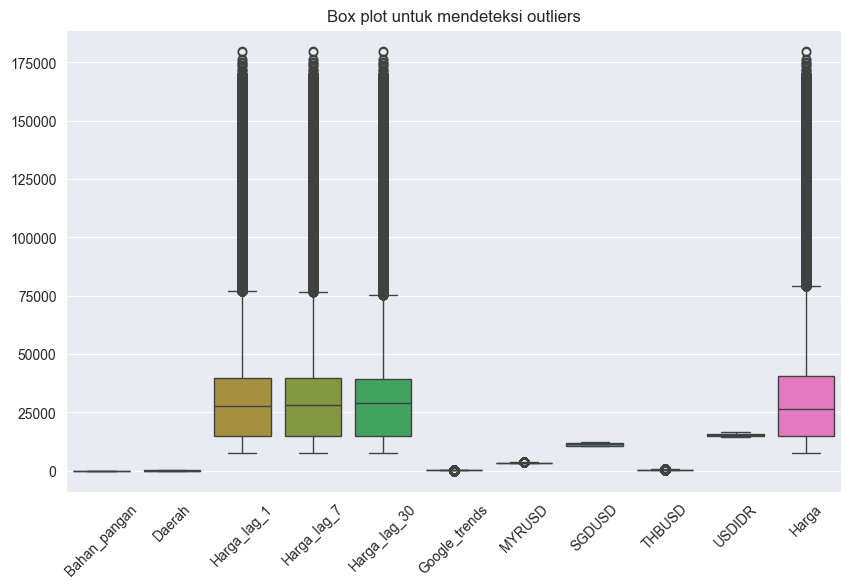

In [46]:
# Visualisasi dengan box plot
plt.figure(figsize=(10, 6))
sns.boxplot(df)
plt.title('Box plot untuk mendeteksi outliers')
plt.xticks(rotation=45)
plt.show()

## &nbsp; 4.1 Outliers of harga_lag_1

**This outliers adjustment uses the IQR (Inter Quartile Range) Technique**

**Bagian ini 4.1 lalu 4.1.1 lalu 4.1.2 di running. Setelah itu balik lagi running 4.1 sampai 4.1.2. Pokok nya cek sampe Boxplotnya gaada outliers. Sama seperti yang lain juga ya (4.2 juga sama dan seterusnya sampe outliers harga)**

In [60]:
# Hitung Q1 dan Q3
Q1 = df['Harga_lag_1'].quantile(0.25)
Q3 = df['Harga_lag_1'].quantile(0.75)

# Hitung IQR
IQR = Q3 - Q1

# Tentukan batas atas dan batas bawah
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Identifikasi outliers
outliers = df[(df['Harga_lag_1'] < lower_bound) | (df['Harga_lag_1'] > upper_bound)]

# Tampilkan outliers
print("Outliers:")
outliers

Outliers:


,Tanggal,Bahan_pangan,Daerah,Harga_lag_1,Harga_lag_7,Harga_lag_30,Google_trends,MYRUSD,SGDUSD,THBUSD,USDIDR,Harga
907,2022-01-02,4,11,"71,580","36,176","36,167",38,3380,11235,435,15213,"75,430"
908,2022-01-02,4,12,"70,710","36,176","36,167",38,3380,11235,435,15213,"59,180"
909,2022-01-02,4,13,"75,030","36,176","36,167",38,3380,11235,435,15213,"74,010"
910,2022-01-02,4,14,"73,790","36,176","36,167",38,3380,11235,435,15213,"72,230"
916,2022-01-02,4,19,"74,100","36,176","36,167",38,3380,11235,435,15213,"69,850"
...,...,...,...,...,...,...,...,...,...,...,...,...
470783,2024-09-30,5,6,"71,700","72,050","64,020",38,3670,11804,467,15118,"70,400"
470788,2024-09-30,5,11,"68,870","71,440","72,750",38,3670,11804,467,15118,"66,110"
470792,2024-09-30,5,15,"75,030","36,176","36,167",38,3670,11804,467,15118,"75,950"
470797,2024-09-30,5,19,"69,310","68,470","74,520",38,3670,11804,467,15118,"64,170"


### 4.1.1 &nbsp; Adjust Outliers harga_lag_1 with Mean

In [61]:
# Hitung Q1 dan Q3
Q1 = df['Harga_lag_1'].quantile(0.25)
Q3 = df['Harga_lag_1'].quantile(0.75)

# Hitung IQR
IQR = Q3 - Q1

# Tentukan batas atas dan batas bawah
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Hitung mean dari kolom 'Harga_lag_1'
mean_harga_lag_1 = df['Harga_lag_1'].mean()

# Ganti nilai outliers dengan mean
df['Harga_lag_1'] = df['Harga_lag_1'].apply(
    lambda x: mean_harga_lag_1 if x < lower_bound or x > upper_bound else x
)

# Tampilkan hasil setelah mengganti outliers
print("Setelah mengganti outliers dengan mean:")
df['Harga_lag_1'].describe()

Setelah mengganti outliers dengan mean:


count   471,048
mean     27,340
std      13,337
min       7,480
25%      14,840
50%      27,860
75%      36,169
max      68,160
Name: Harga_lag_1, dtype: float64

### 4.1.2&nbsp; Boxplot harga_lag_1 After Adjust

**Pokoknya patokan adjustment outliers berhasil kalau Boxplotnya bersih (bebas dari outliers)**

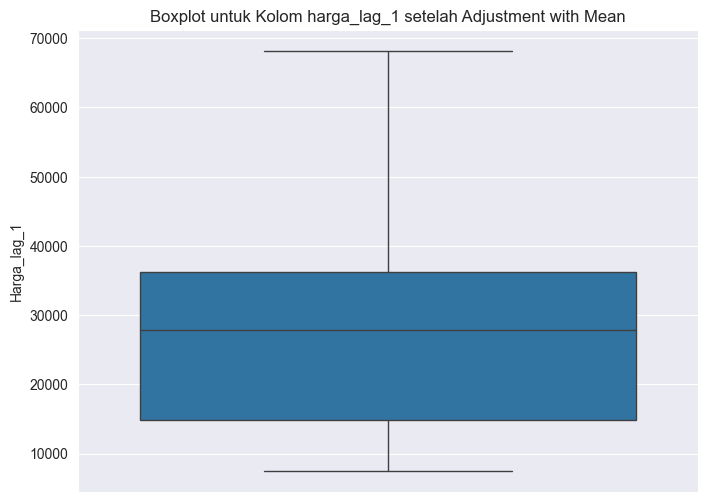

In [62]:
# Membuat boxplot untuk kolom 'harga_lag_1' setelah Adjustment with Mean
plt.figure(figsize=(8, 6))
sns.boxplot(df['Harga_lag_1'])
plt.title('Boxplot untuk Kolom harga_lag_1 setelah Adjustment with Mean')
plt.show()

## &nbsp; 4.2 Outliers of harga_lag_7

In [63]:
# Hitung Q1 dan Q3
Q1 = df['Harga_lag_7'].quantile(0.25)
Q3 = df['Harga_lag_7'].quantile(0.75)

# Hitung IQR
IQR = Q3 - Q1

# Tentukan batas atas dan batas bawah
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Identifikasi outliers
outliers = df[(df['Harga_lag_7'] < lower_bound) | (df['Harga_lag_7'] > upper_bound)]

# Tampilkan outliers
print("Outliers:")
outliers

Outliers:


,Tanggal,Bahan_pangan,Daerah,Harga_lag_1,Harga_lag_7,Harga_lag_30,Google_trends,MYRUSD,SGDUSD,THBUSD,USDIDR,Harga
3559,2022-01-08,4,11,"60,060","71,580","36,167",38,3422,10587,429,14408,"65,510"
3560,2022-01-08,4,12,"60,230","70,710","36,167",38,3422,10587,429,14408,"59,510"
3561,2022-01-08,4,13,"27,963","75,030","36,167",38,3422,10587,429,14408,"70,480"
3562,2022-01-08,4,14,"61,210","73,790","36,167",38,3422,10587,429,14408,"56,350"
3568,2022-01-08,4,19,"66,830","74,100","36,167",38,3422,10587,429,14408,"66,680"
...,...,...,...,...,...,...,...,...,...,...,...,...
470365,2024-09-29,5,30,"27,963","74,310","66,660",38,3640,11738,466,15070,"73,840"
470783,2024-09-30,5,6,"27,963","72,050","64,020",38,3670,11804,467,15118,"70,400"
470788,2024-09-30,5,11,"27,963","71,440","72,750",38,3670,11804,467,15118,"66,110"
470797,2024-09-30,5,19,"27,963","68,470","74,520",38,3670,11804,467,15118,"64,170"


### 4.2.1 &nbsp; Adjust Outliers harga_lag_7 with Mean

In [64]:
# Hitung Q1 dan Q3
Q1 = df['Harga_lag_7'].quantile(0.25)
Q3 = df['Harga_lag_7'].quantile(0.75)

# Hitung IQR
IQR = Q3 - Q1

# Tentukan batas atas dan batas bawah
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Hitung mean dari kolom 'Harga_lag_7'
mean_harga_lag_7 = df['Harga_lag_7'].mean()

# Ganti nilai outliers dengan mean
df['Harga_lag_7'] = df['Harga_lag_7'].apply(
    lambda x: mean_harga_lag_7 if x < lower_bound or x > upper_bound else x
)

# Tampilkan hasil setelah mengganti outliers
print("Setelah mengganti outliers dengan mean:")
df['Harga_lag_7'].describe()

Setelah mengganti outliers dengan mean:


count   471,048
mean     27,400
std      13,325
min       7,480
25%      14,850
50%      28,008
75%      36,176
max      68,160
Name: Harga_lag_7, dtype: float64

### 4.2.2&nbsp; Boxplot harga_lag_7 After Adjust

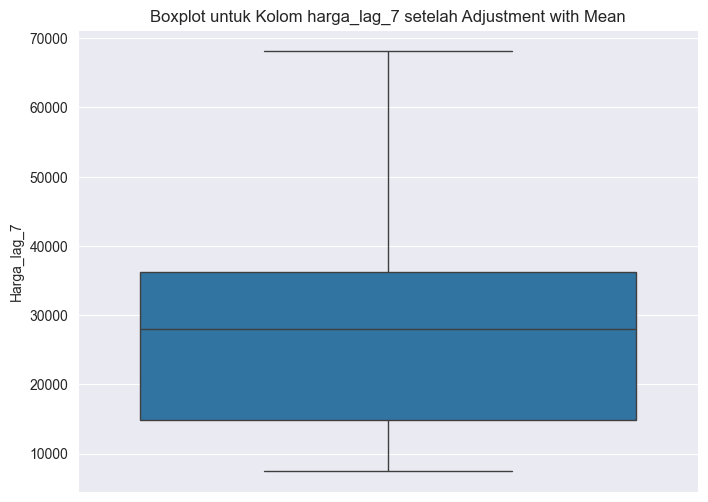

In [65]:
# Membuat boxplot untuk kolom 'harga_lag_7' setelah Adjustment with Mean
plt.figure(figsize=(8, 6))
sns.boxplot(df['Harga_lag_7'])
plt.title('Boxplot untuk Kolom harga_lag_7 setelah Adjustment with Mean')
plt.show()

## &nbsp; 4.3 Outliers of harga_lag_30

In [66]:
# Hitung Q1 dan Q3
Q1 = df['Harga_lag_30'].quantile(0.25)
Q3 = df['Harga_lag_30'].quantile(0.75)

# Hitung IQR
IQR = Q3 - Q1

# Tentukan batas atas dan batas bawah
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Identifikasi outliers
outliers = df[(df['Harga_lag_30'] < lower_bound) | (df['Harga_lag_30'] > upper_bound)]

# Tampilkan outliers
print("Outliers:")
outliers

Outliers:


,Tanggal,Bahan_pangan,Daerah,Harga_lag_1,Harga_lag_7,Harga_lag_30,Google_trends,MYRUSD,SGDUSD,THBUSD,USDIDR,Harga
14167,2022-02-01,4,11,"43,430","43,280","71,580",38,3430,10617,432,14350,"44,320"
14168,2022-02-01,4,12,"43,900","47,390","70,710",38,3430,10617,432,14350,"44,220"
14169,2022-02-01,4,13,"59,810","62,670","75,030",38,3430,10617,432,14350,"58,240"
14170,2022-02-01,4,14,"42,980","48,840","73,790",38,3430,10617,432,14350,"41,590"
14176,2022-02-01,4,19,"54,980","56,440","74,100",38,3430,10617,432,14350,"53,770"
...,...,...,...,...,...,...,...,...,...,...,...,...
470763,2024-09-30,4,19,"57,410","61,370","69,880",38,3670,11804,467,15118,"57,210"
470788,2024-09-30,5,11,"27,963","28,008","72,750",38,3670,11804,467,15118,"66,110"
470790,2024-09-30,5,13,"60,930","63,310","69,250",38,3670,11804,467,15118,"62,410"
470794,2024-09-30,5,17,"65,870","60,060","69,550",38,3670,11804,467,15118,"62,790"


### 4.3.1 &nbsp; Adjust Outliers harga_lag_30 with Mean

In [67]:
# Hitung Q1 dan Q3
Q1 = df['Harga_lag_30'].quantile(0.25)
Q3 = df['Harga_lag_30'].quantile(0.75)

# Hitung IQR
IQR = Q3 - Q1

# Tentukan batas atas dan batas bawah
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Hitung mean dari kolom 'Harga_lag_30'
mean_harga_lag_30 = df['Harga_lag_30'].mean()

# Ganti nilai outliers dengan mean
df['Harga_lag_30'] = df['Harga_lag_30'].apply(
    lambda x: mean_harga_lag_30 if x < lower_bound or x > upper_bound else x
)

# Tampilkan hasil setelah mengganti outliers
print("Setelah mengganti outliers dengan mean:")
df['Harga_lag_30'].describe()

Setelah mengganti outliers dengan mean:


count   471,048
mean     27,608
std      13,244
min       7,480
25%      14,900
50%      28,135
75%      36,167
max      68,060
Name: Harga_lag_30, dtype: float64

### 4.3.2&nbsp; Boxplot harga_lag_30 After Adjust

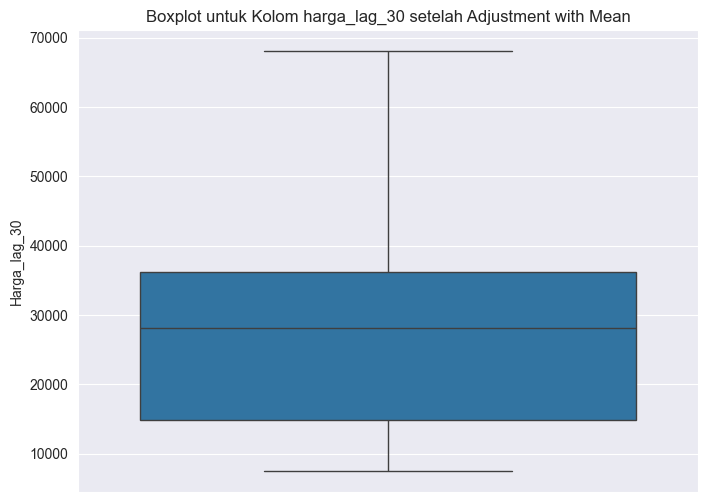

In [68]:
# Membuat boxplot untuk kolom 'harga_lag_30' setelah Adjustment with Mean
plt.figure(figsize=(8, 6))
sns.boxplot(df['Harga_lag_30'])
plt.title('Boxplot untuk Kolom harga_lag_30 setelah Adjustment with Mean')
plt.show()

## &nbsp; 4.4 Outliers of harga

In [69]:
# Hitung Q1 dan Q3
Q1 = df['Harga'].quantile(0.25)
Q3 = df['Harga'].quantile(0.75)

# Hitung IQR
IQR = Q3 - Q1

# Tentukan batas atas dan batas bawah
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Identifikasi outliers
outliers = df[(df['Harga'] < lower_bound) | (df['Harga'] > upper_bound)]

# Tampilkan outliers
print("Outliers:")
outliers

Outliers:


,Tanggal,Bahan_pangan,Daerah,Harga_lag_1,Harga_lag_7,Harga_lag_30,Google_trends,MYRUSD,SGDUSD,THBUSD,USDIDR,Harga
295,2022-01-01,4,11,"36,169","36,176","36,167",38,3380,11235,435,15213,"71,580"
296,2022-01-01,4,12,"36,169","36,176","36,167",38,3380,11235,435,15213,"70,710"
297,2022-01-01,4,13,"36,169","36,176","36,167",38,3380,11235,435,15213,"75,030"
298,2022-01-01,4,14,"36,169","36,176","36,167",38,3380,11235,435,15213,"73,790"
304,2022-01-01,4,19,"36,169","36,176","36,167",38,3380,11235,435,15213,"74,100"
...,...,...,...,...,...,...,...,...,...,...,...,...
470365,2024-09-29,5,30,"27,963","28,008","66,660",38,3640,11738,466,15070,"73,840"
470783,2024-09-30,5,6,"27,963","28,008","64,020",38,3670,11804,467,15118,"70,400"
470792,2024-09-30,5,15,"27,963","36,176","36,167",38,3670,11804,467,15118,"75,950"
470796,2024-09-30,5,20,"36,169","36,176","36,167",38,3670,11804,467,15118,"76,800"


### 4.4.1 &nbsp; Adjust Outliers harga with Mean

In [70]:
# Hitung Q1 dan Q3
Q1 = df['Harga'].quantile(0.25)
Q3 = df['Harga'].quantile(0.75)

# Hitung IQR
IQR = Q3 - Q1

# Tentukan batas atas dan batas bawah
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Hitung mean dari kolom 'Harga'
mean_harga = df['Harga'].mean()

# Ganti nilai outliers dengan mean
df['Harga'] = df['Harga'].apply(
    lambda x: mean_harga if x < lower_bound or x > upper_bound else x
)

# Tampilkan hasil setelah mengganti outliers
print("Setelah mengganti outliers dengan mean:")
df['Harga'].describe()

Setelah mengganti outliers dengan mean:


count   471,048
mean     26,674
std      13,439
min       7,480
25%      14,650
50%      26,170
75%      35,896
max      67,760
Name: Harga, dtype: float64

### 4.4.2&nbsp; Boxplot harga After Adjust

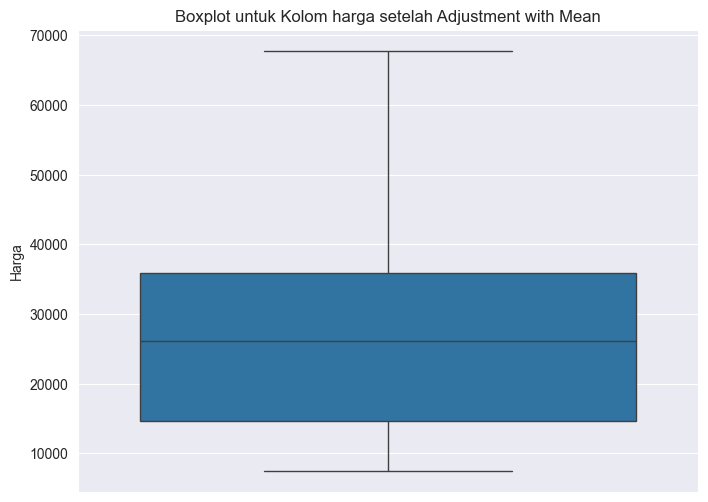

In [71]:
# Membuat boxplot untuk kolom 'harga' setelah Adjustment with Mean
plt.figure(figsize=(8, 6))
sns.boxplot(df['Harga'])
plt.title('Boxplot untuk Kolom harga setelah Adjustment with Mean')
plt.show()

## 4.5&nbsp; Recheck of Outliers All

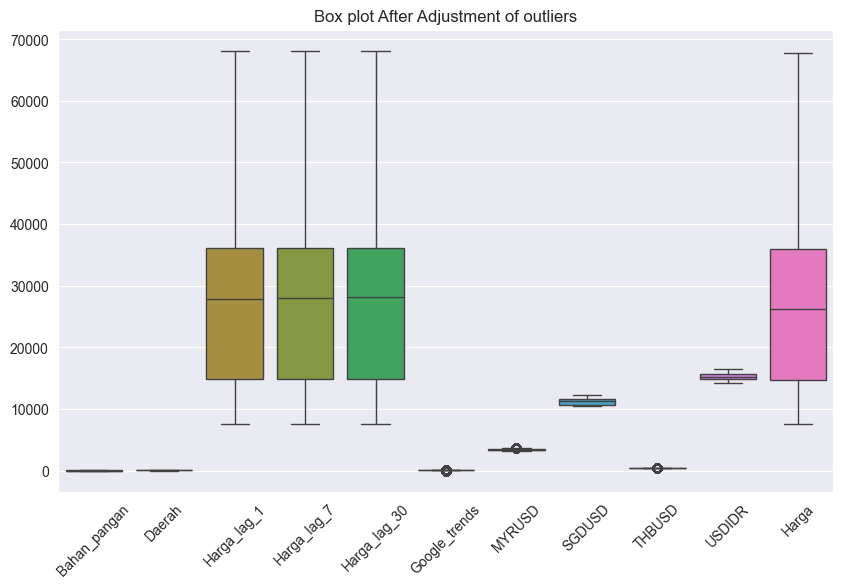

In [72]:
# Visualisasi dengan box plot
plt.figure(figsize=(10, 6))
sns.boxplot(df)
plt.title('Box plot After Adjustment of outliers')
plt.xticks(rotation=45)
plt.show()

# 5.&nbsp;Data Preparation for Modelling

In [73]:
df.columns

Index(['Tanggal', 'Bahan_pangan', 'Daerah', 'Harga_lag_1', 'Harga_lag_7',
       'Harga_lag_30', 'Google_trends', 'MYRUSD', 'SGDUSD', 'THBUSD', 'USDIDR',
       'Harga'],
      dtype='object')

## 5.1&nbsp; Train-Test Split

In [147]:
# # Pisahkan fitur dan target
# X = df.drop('Harga', axis=1)
# y = df['Harga']

# X=df.drop(['Harga', 'Harga_lag_1', 'Harga_lag_7', 'Harga_lag_30', 'MYRUSD', 'SGDUSD', 'THBUSD', 'USDIDR', 'Google_trends'], axis=1)
X=df.drop(['Harga', 'Harga_lag_1', 'Harga_lag_7', 'Harga_lag_30', 'Google_trends'], axis=1)
y=df['Google_trends']

In [148]:
# Lakukan train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [149]:
X_train['Year'] = X_train['Tanggal'].dt.year
X_train['Month'] = X_train['Tanggal'].dt.month
X_train['Day'] = X_train['Tanggal'].dt.day
X_train['Weekday'] = X_train['Tanggal'].dt.weekday  # Senin (0) - Minggu (6)

X_test['Year'] = X_test['Tanggal'].dt.year
X_test['Month'] = X_test['Tanggal'].dt.month
X_test['Day'] = X_test['Tanggal'].dt.day
X_test['Weekday'] = X_test['Tanggal'].dt.weekday

In [157]:
X['Year'] = X['Tanggal'].dt.year
X['Month'] = X['Tanggal'].dt.month
X['Day'] = X['Tanggal'].dt.day
X['Weekday'] = X['Tanggal'].dt.weekday  # Senin (0) - Minggu (6)

In [158]:
# Hapus kolom 'Tanggal' karena sudah dipecah menjadi fitur numerik
X_train = X_train.drop(columns=['Tanggal'])
X_test = X_test.drop(columns=['Tanggal'])

In [ ]:
# Hapus kolom 'Tanggal' karena sudah dipecah menjadi fitur numerik
X = X.drop(columns=['Tanggal'])

In [159]:
X.head()

,Bahan_pangan,Daerah,Year,Month,Day,Weekday
0,0,0,2024,10,1,1
1,0,1,2024,10,1,1
2,0,2,2024,10,1,1
3,0,3,2024,10,1,1
4,0,4,2024,10,1,1


## 5.2&nbsp; Scaling

In [160]:
# Buat pipeline dengan preprocessing
pipeline = Pipeline([
    ('quantile_transform', QuantileTransformer(output_distribution='normal')),
    ('scaler', StandardScaler())  # Scaling fitur
])

## 5.3&nbsp; PreProcess Data train & test

In [154]:
pipeline.fit(X_train)
X_train_transformed = pipeline.transform(X_train)
X_test_transformed = pipeline.transform(X_test)

In [161]:
pipeline.fit(X)
X_transformed = pipeline.transform(X)

# &nbsp; 6. Modelling

## &nbsp; 6.1 XGBoost without Tuning

In [81]:
# Inisialisasi model XGBoost untuk regresi
xgb_model = xgb.XGBRegressor(random_state=42)

# Latih model pada data latih yang telah ditransformasi
xgb_model.fit(X_train_transformed, y_train)

# Prediksi pada data uji yang telah ditransformasi
y_pred_xgb = xgb_model.predict(X_test_transformed)

# Evaluasi model dengan MAPE
mape_score = mean_absolute_percentage_error(y_test, y_pred_xgb)

print("XGBoost Regressor:")
print("Mean Absolute Percentage Error (MAPE):", mape_score)

XGBoost Regressor:
Mean Absolute Percentage Error (MAPE): 0.13344642519950867


Gunakan MAPE sebagai evaluasi utama (semakin kecil, semakin baik).

Hasil MAPE = 0.0236 berarti error rata-rata model hanya sekitar 2.36% dari nilai sebenarnya. Ini menunjukkan model XGBoost Regressor bekerja dengan baik dalam memprediksi harga bahan pangan! 🎯🔥

## &nbsp; 6.2 XGBoost with Hyperparameter Tuning

Kode ini blm aku running karena pasti lama. soale laptopku bapuk. klo laptop yg bagus harusnya ga lama

In [87]:
# Inisialisasi model XGBoost Regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Definisikan hyperparameter yang akan dituning
param_dist = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.1, 0.5, 1, 5]
}

# Inisialisasi RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,  # Ubah jumlah iterasi sesuai kebutuhan
    scoring='neg_mean_absolute_percentage_error',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Jalankan tuning pada data latih
random_search.fit(X_train_transformed, y_train)

# Cetak hyperparameter terbaik
print("Best Hyperparameters:", random_search.best_params_)

# Gunakan model terbaik untuk prediksi
best_xgb = random_search.best_estimator_
y_pred_best = best_xgb.predict(X_test_transformed)

# Hitung MAPE
mape_best = mean_absolute_percentage_error(y_test, y_pred_best)
print(f"MAPE setelah tuning: {mape_best:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Hyperparameters: {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}
MAPE setelah tuning: 0.1179


In [88]:
# Save the best model to a file
best_xgb.save_model('google_trends_xgboost_regressor_model.json')

# 7. Forecasting 

In [176]:
# Load the saved model
best_xgb = xgb.XGBRegressor()
best_xgb.load_model('google_trends_xgboost_regressor_model.json')

In [177]:
Data_transformed = pd.DataFrame(X_transformed, columns=['Bahan_pangan', 'Daerah', 'Year', 'Month', 'Day', 'Weekday'])

In [178]:
result = best_xgb.predict(X_transformed)

In [183]:
X['Google_trends']=result

In [184]:
X

,Bahan_pangan,Daerah,Year,Month,Day,Weekday,Google_trends
0,0,0,2024,10,1,1,36
1,0,1,2024,10,1,1,41
2,0,2,2024,10,1,1,30
3,0,3,2024,10,1,1,35
4,0,4,2024,10,1,1,35
...,...,...,...,...,...,...,...
40659,12,29,2024,12,31,1,38
40660,12,30,2024,12,31,1,38
40661,12,31,2024,12,31,1,37
40662,12,32,2024,12,31,1,37


In [187]:
result

array([35.722317, 40.506355, 30.250156, ..., 37.48249 , 37.14172 ,
       37.14172 ], dtype=float32)

In [188]:
X.to_csv('google_trends_result_forecasting.csv', index=False)